In [ ]:
from pathlib import Path

# Main project root path
ROOT = Path("C:/DOCTORAL HUB/nmr_pipeline_project")

# List of all subfolders
folders = [
    "data/raw",
    "data/curated/verified",
    "data/descriptors",
    "data/merged",
    "data/models",
    "data/results",
    "data/reports",
    "logs",
    "notebooks",
    "scripts",
]

# Create all subfolders
for f in folders:
    (ROOT / f).mkdir(parents=True, exist_ok=True)

print(" Project folders created at:", ROOT.resolve())
for f in folders:
    print(" -", f)


Project folders created at: C:\DOCTORAL HUB\nmr_pipeline_project
 - data/raw
 - data/curated/verified
 - data/descriptors
 - data/merged
 - data/models
 - data/results
 - data/reports
 - logs
 - notebooks
 - scripts


In [ ]:
from rdkit import Chem
import pandas as pd, re, json
from pathlib import Path
from datetime import datetime

# === Setup paths ===
ROOT = Path("C:/DOCTORAL HUB/nmr_pipeline_project")
RAW = ROOT / "data" / "raw"
CUR = ROOT / "data" / "curated"
LOG = ROOT / "logs"

CUR.mkdir(parents=True, exist_ok=True)
LOG.mkdir(parents=True, exist_ok=True)

# === Helper functions ===
def clean(v):
    return v.replace("\\", "").strip()

def first(props, *keys):
    for k in keys:
        if k in props and props[k].strip():
            return clean(props[k])
    return None

def parse_assign_block(block):
    """
    NMREDATA_ASSIGNMENT lines look like:
    s0, 17.6, 11
    s1, 22.3, 2,5
    -> (shift_ppm, atom_index)
    """
    out = []
    if not block:
        return out
    for raw in block.splitlines():
        line = raw.strip()
        if not line:
            continue
        if "=" in line and line.split("=")[0] in ("Spectrum_Location", "Larmor"):
            continue

        parts = [p.strip() for p in re.split("[,;]", line) if p.strip()]
        if len(parts) < 3:
            continue

        try:
            shift_val = float(parts[1])
        except:
            continue

        for possible_idx in parts[2:]:
            if possible_idx.isdigit():
                out.append((shift_val, int(possible_idx)))
    return out

# === Load SDF file ===
sdf_file = next(RAW.glob("*.sd*"))
supplier = Chem.SDMolSupplier(str(sdf_file), sanitize=False)

molecule_rows = []
assignment_rows = []
log_path = LOG / "phase1.log"

# === Main extraction loop ===
with open(log_path, "w", encoding="utf-8") as logf:
    for mol_idx, mol in enumerate(supplier, start=1):
        if mol is None:
            logf.write(f"[WARN] molecule {mol_idx} could not be parsed\n")
            continue

        props = {p: mol.GetProp(p) for p in mol.GetPropNames()}

        name = mol.GetProp("_Name") if mol.HasProp("_Name") else ""
        smiles = first(props, "NMREDATA_SMILES") or Chem.MolToSmiles(mol, canonical=False)
        inchi = first(props, "NMREDATA_INCHI") or ""
        solvent = first(props, "NMREDATA_SOLVENT") or ""
        temp_k = None
        if "NMREDATA_TEMPERATURE" in props:
            nums = re.findall(r"[0-9]+(?:\.[0-9]+)?", props["NMREDATA_TEMPERATURE"])
            if nums:
                temp_k = float(nums[0])

        n_atoms = mol.GetNumAtoms()
        has_13c = any(k in props for k in ("NMREDATA_1D_13C", "NMREDATA_1D_13C#1", "NMREDATA_1D_13C#2"))
        has_1h = any(k in props for k in ("NMREDATA_1D_1H", "NMREDATA_1D_1H#1", "NMREDATA_1D_1H#2"))

        molecule_rows.append({
            "mol_idx": mol_idx,
            "name": name,
            "smiles": smiles,
            "inchi": inchi,
            "solvent": solvent,
            "temperature_k": temp_k,
            "has_13c": has_13c,
            "has_1h": has_1h,
            "n_atoms": n_atoms,
        })

        assign_block = first(props, "NMREDATA_ASSIGNMENT", "NMREDATA_ASSIGNMENT#1", "NMREDATA_ASSIGNMENT#2")
        if assign_block:
            pairs = parse_assign_block(assign_block)
            for shift_ppm, atom_num in pairs:
                if 1 <= atom_num <= n_atoms:
                    atom = mol.GetAtomWithIdx(atom_num - 1)
                    assignment_rows.append({
                        "mol_idx": mol_idx,
                        "atom_index": atom_num,
                        "element": atom.GetSymbol(),
                        "shift_ppm": shift_ppm
                    })
                else:
                    logf.write(f"[WARN] mol {mol_idx}: atom index {atom_num} out of range\n")

# === Save results ===
mols_df = pd.DataFrame(molecule_rows)
assign_df = pd.DataFrame(assignment_rows)

mols_df.to_csv(CUR / "molecules.csv", index=False)
assign_df.to_csv(CUR / "assignments.csv", index=False)

summary = {
    "molecules_total": len(mols_df),
    "assignments_total": len(assign_df),
    "timestamp": datetime.now().isoformat()
}
with open(CUR / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Data extraction completed!")
print(summary)


[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 33 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 33 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 11 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 11 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 31 ignored.
[10:34:13] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 68 ignored.
[10:34:13] Warning: ambiguous stereoc

Data extraction completed!
{'molecules_total': 64587, 'assignments_total': 687380, 'timestamp': '2025-10-24T10:34:33.298973'}


In [1]:
# Verification & Cleaning
import pandas as pd
from pathlib import Path
from datetime import datetime
import json

ROOT = Path("C:/DOCTORAL HUB/nmr_pipeline_project")
CUR = ROOT / "data" / "curated"
VER = CUR / "verified"
LOG = ROOT / "logs"

VER.mkdir(parents=True, exist_ok=True)

# Load data
mols = pd.read_csv(CUR / "molecules.csv")
assigns = pd.read_csv(CUR / "assignments.csv")

print(f"Loaded {len(mols):,} molecules and {len(assigns):,} assignments")

# Remove duplicates or missing data
assigns = assigns.dropna(subset=["shift_ppm"])
assigns = assigns[assigns["shift_ppm"].between(-10, 400)]  # Reasonable ppm range

# Remove molecules with no valid assignments
valid_mols = assigns["mol_idx"].unique()
mols_clean = mols[mols["mol_idx"].isin(valid_mols)].copy()

# Save verified versions
mols_clean.to_csv(VER / "molecules_verified.csv", index=False)
assigns.to_csv(VER / "assignments_verified.csv", index=False)

# Summary report
report = {
    "verified_molecules": len(mols_clean),
    "verified_assignments": len(assigns),
    "timestamp": datetime.now().isoformat()
}

with open(LOG / "verification.log", "w") as f:
    json.dump(report, f, indent=2)

print(" Verification complete.")
print(report)


Loaded 64,587 molecules and 687,380 assignments
 Verification complete.
{'verified_molecules': 61215, 'verified_assignments': 678775, 'timestamp': '2025-10-24T11:14:07.442923'}


 PHASE 1 — VERIFIED DATA SUMMARY
Total Molecules: 61,215
Total Assignments: 678,775
Avg Assignments per Molecule: 11.09

--- Solvent Distribution (Top 10) ---
Unreported     : 40,074
Unknown        : 15,404
CDCl3          : 3,230
D2O            : 586
DMSO-D6, C2D6SO: 520
CD3OD          : 383
(CD3)2CO       : 186
CCl4           : 140
C5D5N          : 101
C6D6           : 96

--- Temperature (Kelvin) ---
Mean: 298.7 | Median: 298.0 | Min: 0.0 | Max: 571.2

--- NMR Shift Stats (ppm) ---
Min: -10.00 | Max: 389.80 | Mean: 72.10 | Median: 56.80

 Summary table saved to: C:\DOCTORAL HUB\nmr_pipeline_project\data\reports\phase1_summary.csv


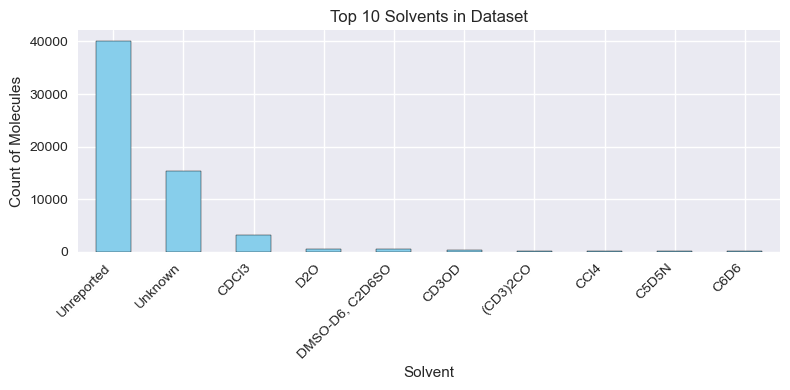

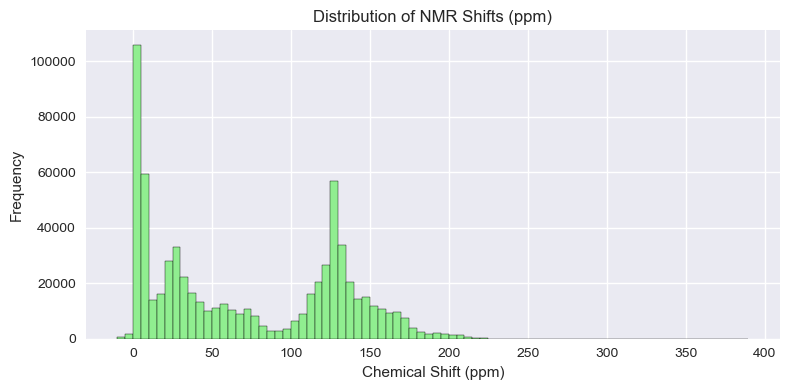

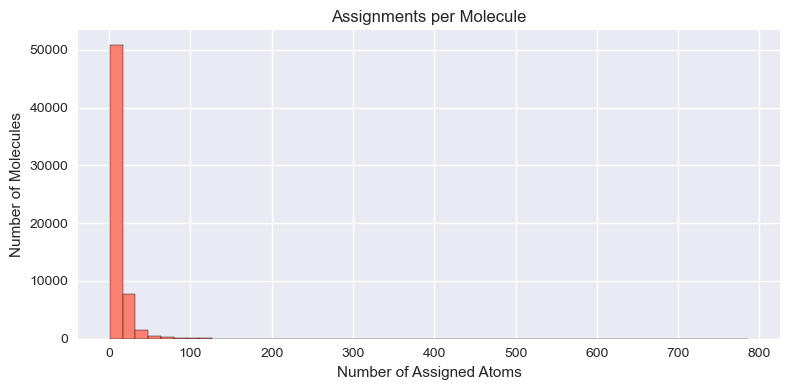


 Visual summary successfully!


In [3]:
# Summary Report : Phase 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths ---
ROOT = Path("C:/DOCTORAL HUB/nmr_pipeline_project")
VER = ROOT / "data" / "curated" / "verified"
REP = ROOT / "data" / "reports"
REP.mkdir(parents=True, exist_ok=True)

# --- Load data ---
mols = pd.read_csv(VER / "molecules_verified.csv")
assigns = pd.read_csv(VER / "assignments_verified.csv")

# === TEXT SUMMARY ===
print("="*60)
print(" PHASE 1 — VERIFIED DATA SUMMARY")
print("="*60)
print(f"Total Molecules: {len(mols):,}")
print(f"Total Assignments: {len(assigns):,}")
print(f"Avg Assignments per Molecule: {assigns.groupby('mol_idx').size().mean():.2f}")

# Solvent Distribution
print("\n--- Solvent Distribution (Top 10) ---")
solvents = mols["solvent"].fillna("Unknown").value_counts().head(10)
for s, c in solvents.items():
    print(f"{s:15s}: {c:,}")

# Temperature
if "temperature_k" in mols.columns:
    temps = mols["temperature_k"].dropna()
    if len(temps) > 0:
        print("\n--- Temperature (Kelvin) ---")
        print(f"Mean: {temps.mean():.1f} | Median: {temps.median():.1f} | "
              f"Min: {temps.min():.1f} | Max: {temps.max():.1f}")
    else:
        print("\nNo temperature data available.")
else:
    print("\nNo temperature column found.")

# Shift Stats
print("\n--- NMR Shift Stats (ppm) ---")
print(f"Min: {assigns['shift_ppm'].min():.2f} | "
      f"Max: {assigns['shift_ppm'].max():.2f} | "
      f"Mean: {assigns['shift_ppm'].mean():.2f} | "
      f"Median: {assigns['shift_ppm'].median():.2f}")

# Save numeric summary
summary = {
    "verified_molecules": len(mols),
    "verified_assignments": len(assigns),
    "avg_assign_per_mol": assigns.groupby("mol_idx").size().mean(),
    "shift_min": assigns["shift_ppm"].min(),
    "shift_max": assigns["shift_ppm"].max(),
    "shift_mean": assigns["shift_ppm"].mean(),
    "shift_median": assigns["shift_ppm"].median(),
}
pd.DataFrame(summary.items(), columns=["Metric", "Value"]).to_csv(REP / "phase1_summary.csv", index=False)

print("\n Summary table saved to:", REP / "phase1_summary.csv")

# === VISUALIZATION SECTION ===
plt.style.use("seaborn-v0_8")

# 1️ Solvent distribution
plt.figure(figsize=(8, 4))
solvents.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 10 Solvents in Dataset")
plt.xlabel("Solvent")
plt.ylabel("Count of Molecules")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2️ NMR Shift Histogram
plt.figure(figsize=(8, 4))
assigns["shift_ppm"].hist(bins=80, color="lightgreen", edgecolor="black")
plt.title("Distribution of NMR Shifts (ppm)")
plt.xlabel("Chemical Shift (ppm)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 3️ Assignments per molecule distribution
mol_counts = assigns.groupby("mol_idx").size()
plt.figure(figsize=(8, 4))
mol_counts.hist(bins=50, color="salmon", edgecolor="black")
plt.title("Assignments per Molecule")
plt.xlabel("Number of Assigned Atoms")
plt.ylabel("Number of Molecules")
plt.tight_layout()
plt.show()

print("\n Visual summary successfully!")